*In this notebook I present the algorithm, I explain how to use it and I compare it with other classical clustering algorithms in some simple (but explicative) datasets*

In [1]:
import os
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons
from sklearn.metrics import f1_score, davies_bouldin_score, silhouette_score, calinski_harabasz_score
from itertools import cycle, islice

from fastdensitypeaks import FastDensityPeaks
np.random.seed(0)

### How to use the algorithm

Here I create a simple dataset just to show how the algorithm works. Some details about the parameters:
- With verbose=True the decision graph (delta as function of rho) is authomatically displayed during the fit
- With autoassign=True the algorithm retrieves automatically the centroids. This method is a my addition to the original algorithm and it simply retrieves the outliers of the rho/delta decision graph using the z_scores of delta. It's euristich and sometimes can fail.
- The fraction parameter (in the fit method) it is used to retrieve authomatically the cutoff parameter dc. Basically, if we set it to 0.02, the cutoff will be defined so that the average number of neighbours will be the 2% of the data
- The fit_predict method returns the labels of the clusters (authomatically uses the autoassign function)
- Since the algorithm is performed one shot on all the data, a predict method doesn't make sense in this case

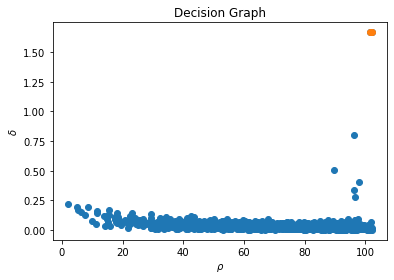

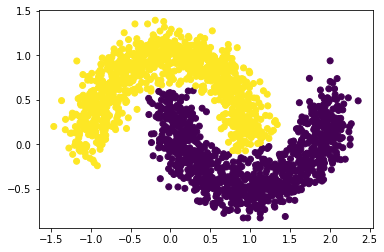

Algorithm runned in a dataset with 2000 instances in 0.68 seconds


In [2]:
x, _ = make_moons(n_samples=2000, noise=0.15, random_state=0)

fdp = FastDensityPeaks(verbose=True, autoassign=True)

t0 = time.time()
labels = fdp.fit_predict(x) # Aternative: fdp.fit(X)
t1 = time.time()

plt.scatter(x[:,0], x[:,1], c=labels) # Alternative: fdp.labels_
plt.show()

print('Algorithm runned in a dataset with {} instances in {:.2f} seconds'.format(x.shape[0],t1-t0))

We can also use the decision_graph method to tell manually the algorithm were to look for the centroids. The cluster indexed are returned

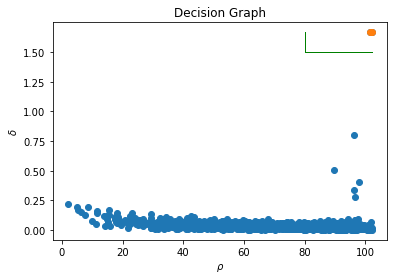

Cluster indexes:  [  88 1876]


In [3]:
fdp.decision_graph(80, 1.5)

The algorithm is also able to retrieve an additional cluster called HALO, in which are contained the points that could be eventually considered noise

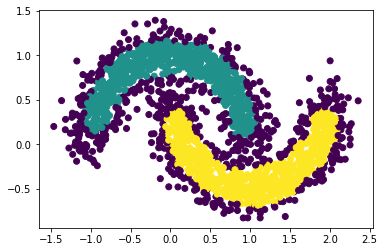

In [4]:
labels_with_halo = fdp.get_halo()
plt.scatter(x[:,0], x[:,1], c=labels_with_halo)

### Autoassign

Here we can see how my little modification to the algorithm makes it able to retrieve automatically the centroids from the delta/rho decision graph. Many decision graphs are shown for different toy datasets and the automatically retrieved centroids are shown

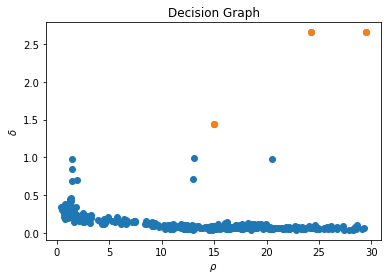

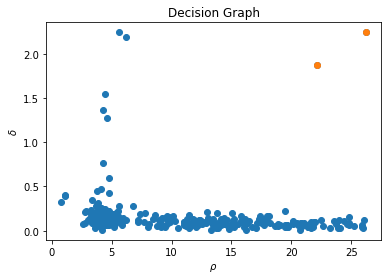

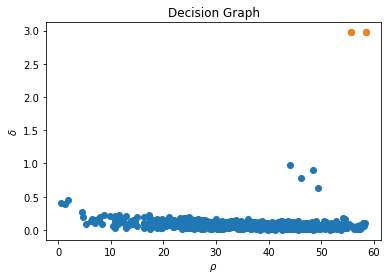

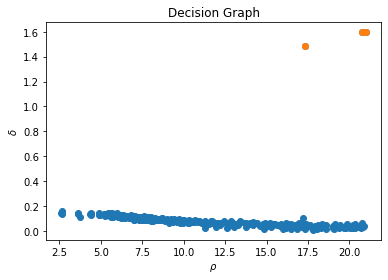

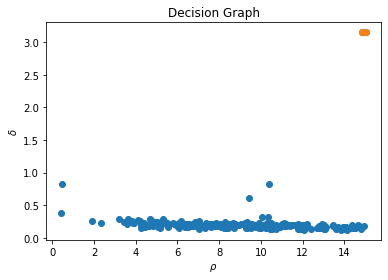

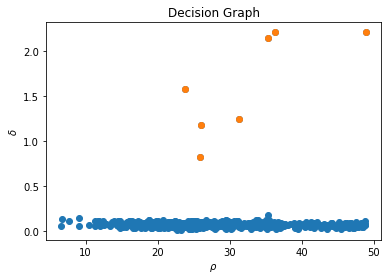

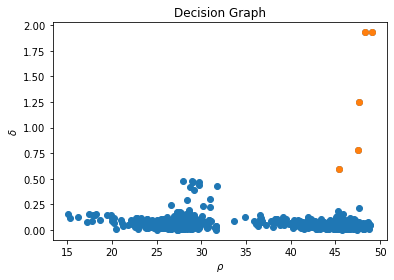

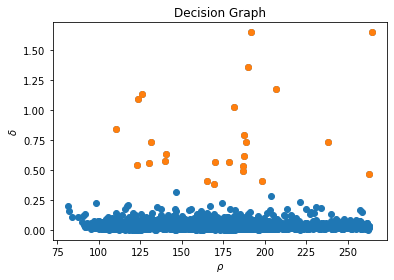

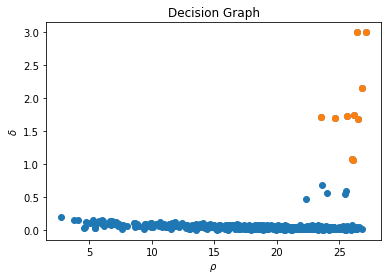

In [5]:
data_folder = 'datasets/toy'
datasets = [d for d in os.listdir(data_folder) if d[-3:]=='csv']
for dataset in datasets:
    X = np.loadtxt(os.path.join(data_folder,dataset))
    X = StandardScaler().fit_transform(X)
    fdp = FastDensityPeaks(autoassign=True)
    fdp.fit(X) 

### Comparison with other clustering algorithms

In the next section I'm gonna display some plots in which the resulting clusters of different clustering algorithms will be compared. Notice that FastDensityPeaks is the only one that doesn't need any parameter (even more evident in the autoassign mode)

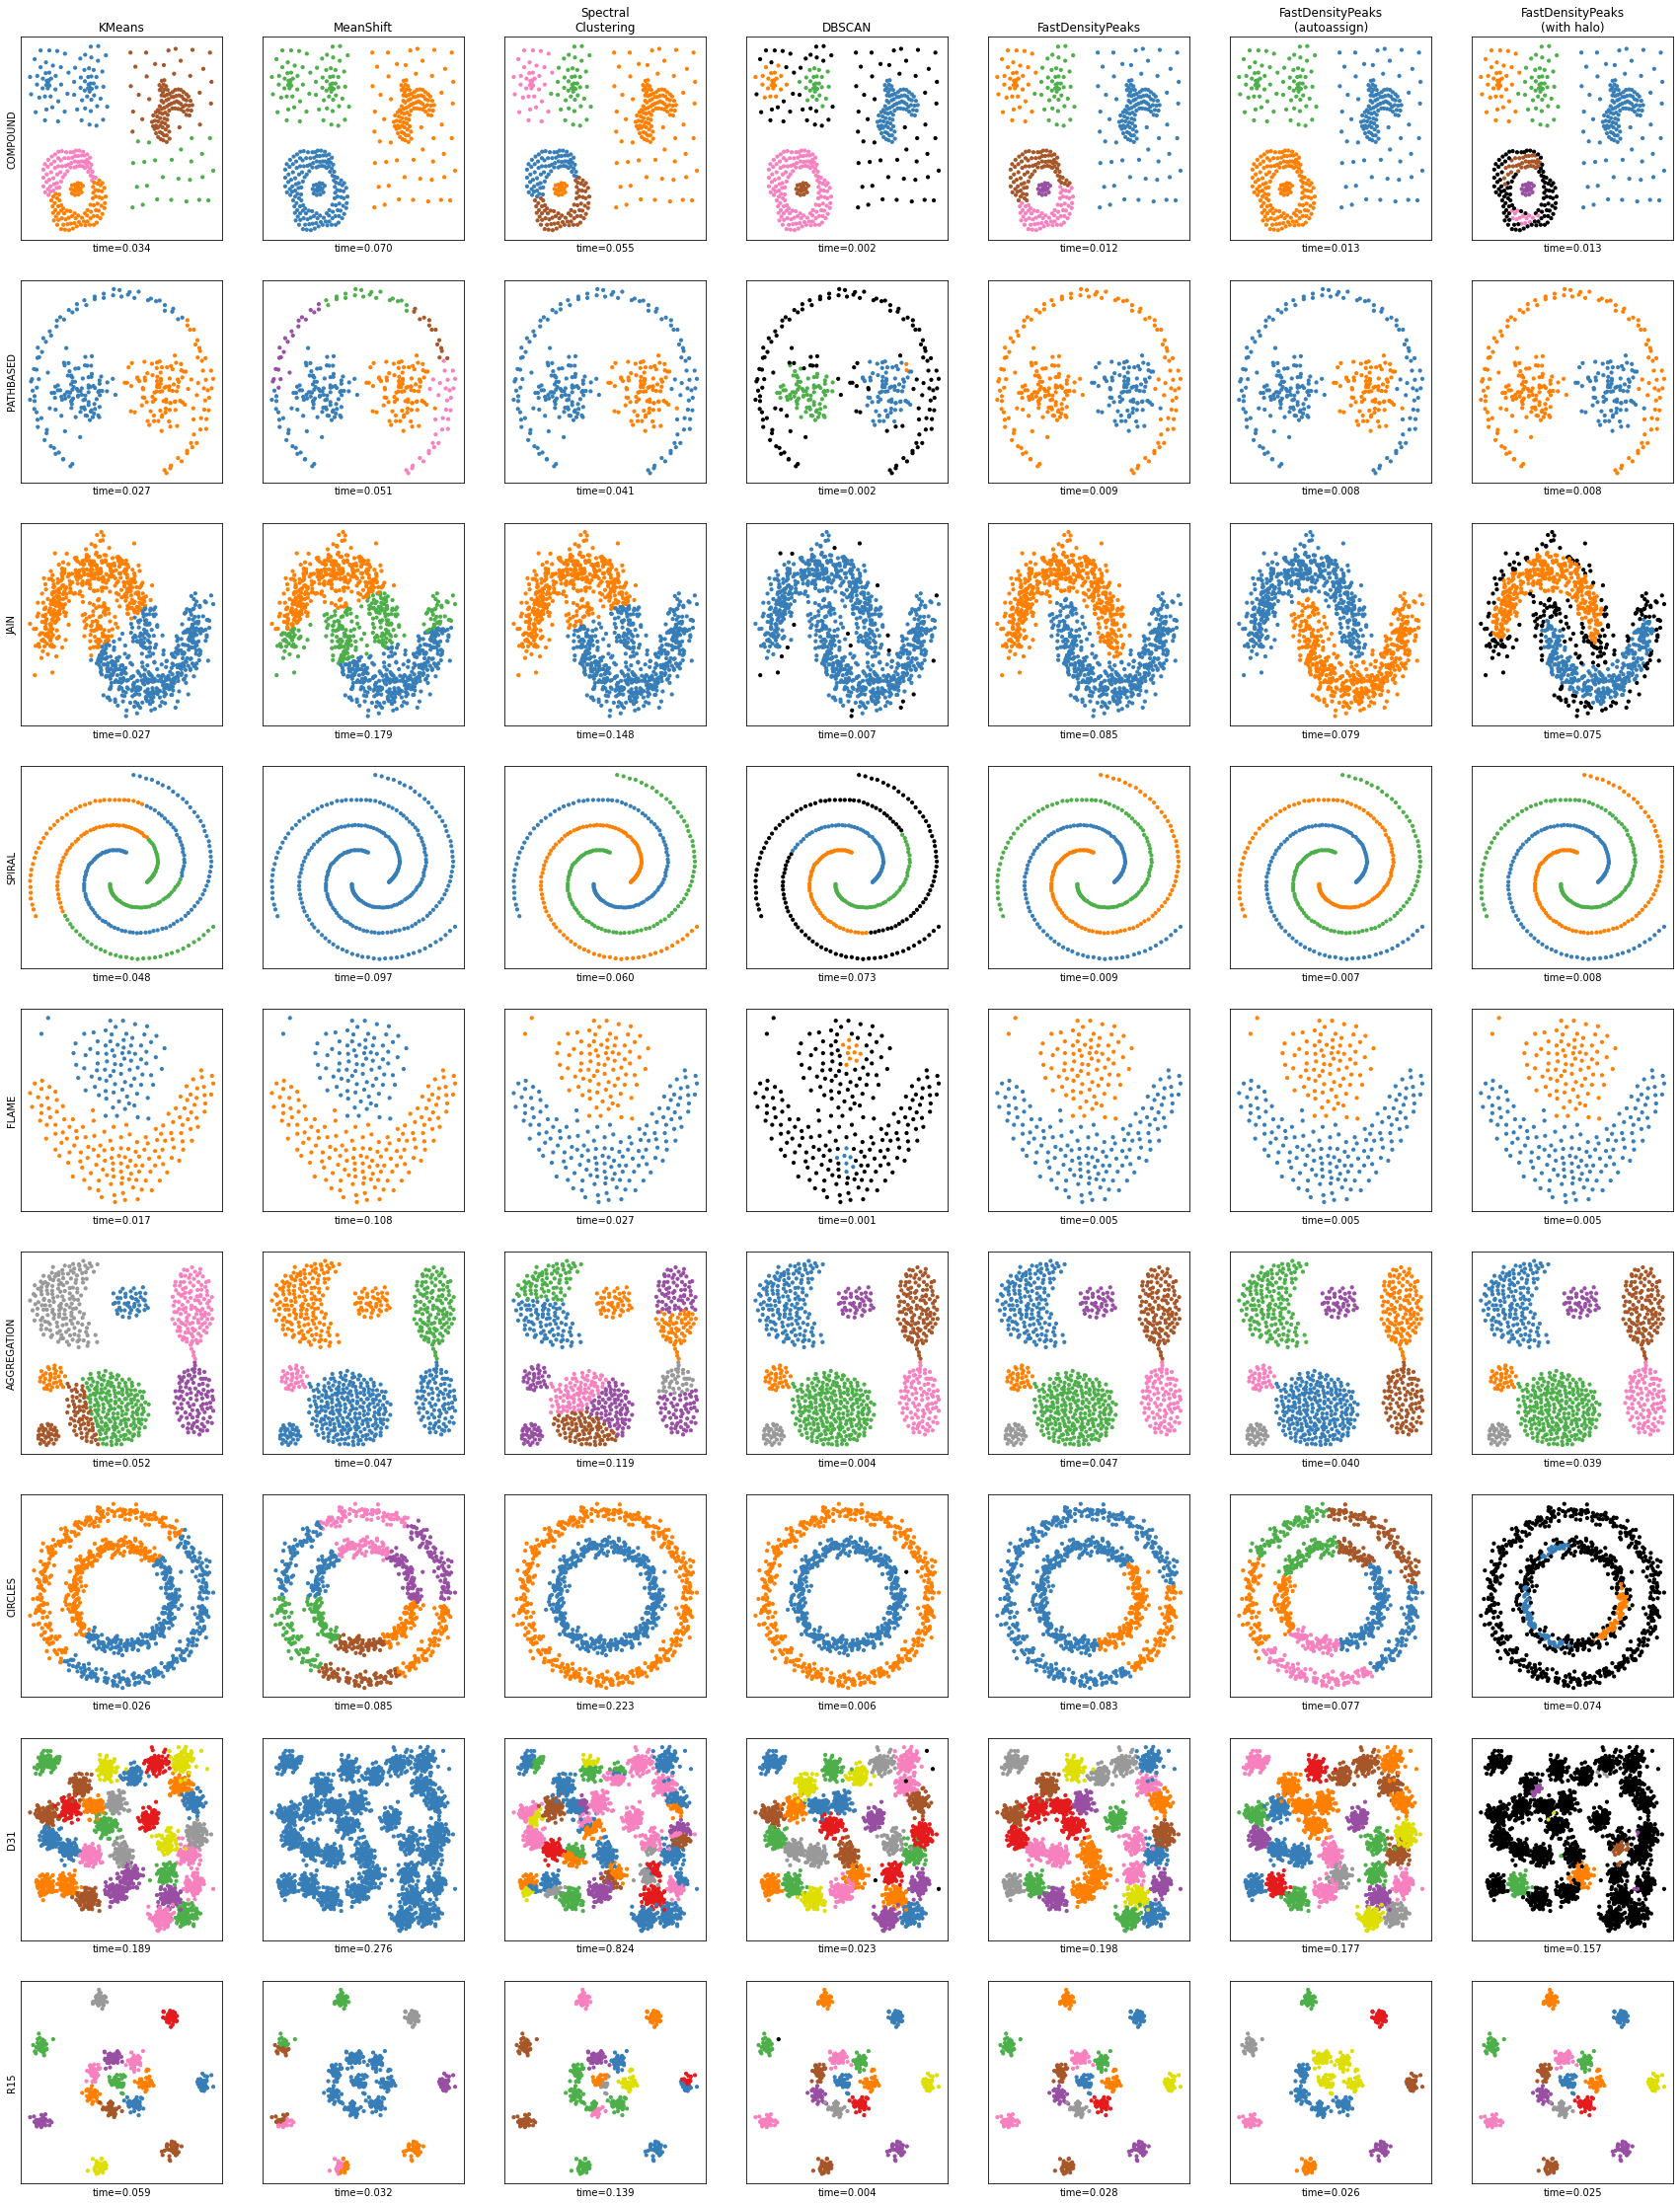

In [6]:
data_folder = 'datasets/toy'
datasets = [d[:-4] for d in os.listdir(data_folder) if d[-3:]=='csv']
n_clusters = [5,2,2,3,2,7,2,31,15] # ground trouth n_clusters, serves for k-means ecc.
graph_decisions = [(10,0.5),(20,1.5),(30,2),(15,1.2),(8,2),(20,0.5),(40,1.5),(80,0.25),(20,0.3)] # for fdp, retrieved from the plots above

fig, ax = plt.subplots(len(datasets), 7, figsize=(30, 40))

for i_dataset, dataset in enumerate(datasets):

    X = np.loadtxt(os.path.join(data_folder,dataset+'.csv'))
    X = StandardScaler().fit_transform(X) # normalize dataset for easier parameter selection

    """Create cluster objects"""
    #Mean Shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=.2)
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    #Kmeans
    kmeans = cluster.KMeans(n_clusters=n_clusters[i_dataset])
    #Spectral Clustering
    spectral = cluster.SpectralClustering(n_clusters=n_clusters[i_dataset], eigen_solver='arpack', affinity="nearest_neighbors")
    #Dbscan
    dbscan = cluster.DBSCAN(eps=.18)
    # FastDensityPeaks
    fdp = FastDensityPeaks(verbose=False, autoassign=False)
    # FastDensityPeaks with autoassign
    fdp_auto = FastDensityPeaks(verbose=False, autoassign=True)

    clustering_algorithms = (('KMeans', kmeans),('MeanShift', ms),
                             ('Spectral\nClustering', spectral),('DBSCAN', dbscan),
                             ('FastDensityPeaks', fdp),('FastDensityPeaks\n(autoassign)', fdp_auto),
                             ('FastDensityPeaks\n(with halo)', fdp))
    
    
    """Fit the algorithms and plot the results"""
    for i_algorithm, (name, algorithm) in enumerate(clustering_algorithms):
        
        # Avoid annoying spectral clustering warning while fitting the algorithms
        with warnings.catch_warnings(): 
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
    
            t0 = time.time()
            algorithm.fit(X)
            if name == 'FastDensityPeaks' or name == 'FastDensityPeaks\n(with halo)':
                algorithm.decision_graph(*graph_decisions[i_dataset])
            t1 = time.time()
    
    
        # Get the labels
        if name == 'FastDensityPeaks\n(with halo)':
            y_pred = algorithm.get_halo()
        elif hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)
            

        # Color palette (to display consistent plots)
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),int(max(y_pred) + 1))))
        
        
        colors = np.append(colors, ["#000000"])# add black color for outliers (if any)
        ax[i_dataset,i_algorithm].scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
        ax[i_dataset,i_algorithm].set_xticks(())
        ax[i_dataset,i_algorithm].set_yticks(())
        if i_dataset == 0:
            ax[i_dataset,i_algorithm].set_title(name)
        if i_algorithm == 0:
            ax[i_dataset,i_algorithm].set_ylabel(dataset.upper())
        ax[i_dataset,i_algorithm].set_xlabel('time={:.3f}'.format(t1-t0))

plt.savefig('results/toy_datasets.png',bbox_inches = 'tight',pad_inches = 0.2)
plt.show()

### Evaluation metrics

In the next cell I'll use some usual evaluation metrics to compare the results obtained with the clustering algorithms considered above

In [7]:
data_folder = 'datasets/toy'
datasets = [d[:-4] for d in os.listdir(data_folder) if d[-3:]=='csv']
n_clusters = [5,2,2,3,2,7,2,29,31] # ground trouth n_clusters, serves for k-means ecc.
graph_decisions = [(10,0.5),(1,1),(30,2),(15,1.2),(8,2),(20,0.5),(40,1.5),(80,0.25),(20,0.3)] # for fdp, retrieved from the plots above

# Define the evauluation metrics
metrics = {'Davies Bouldin': davies_bouldin_score,'Silhouette': silhouette_score, 'Calinksi': calinski_harabasz_score}
# Prepare the dataframe
idx1 = np.repeat(datasets, len(metrics))
idx2 = np.tile(list(metrics.keys()), len(datasets))
df = pd.DataFrame(columns=['KMeans','MeanShift','SpectralClustering','DBSCAN','FastDensityPeaks',
                           'FastDensityPeaks(autoassign)','FastDensityPeaks(with halo)'], index=[idx1, idx2])

for i_dataset, dataset in enumerate(datasets):

    X = np.loadtxt(os.path.join(data_folder,dataset+'.csv'))
    X = StandardScaler().fit_transform(X) # normalize dataset for easier parameter selection

    """Create cluster objects"""
    #Mean Shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=.2)
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    #Kmeans
    kmeans = cluster.KMeans(n_clusters=n_clusters[i_dataset])
    #Spectral Clustering
    spectral = cluster.SpectralClustering(n_clusters=n_clusters[i_dataset], eigen_solver='arpack', affinity="nearest_neighbors")
    #Dbscan
    dbscan = cluster.DBSCAN(eps=.18)
    # FastDensityPeaks
    fdp = FastDensityPeaks(verbose=False, autoassign=False)
    # FastDensityPeaks with autoassign
    fdp_auto = FastDensityPeaks(verbose=False, autoassign=True)

    clustering_algorithms = (('KMeans', kmeans),('MeanShift', ms),
                             ('SpectralClustering', spectral),('DBSCAN', dbscan),
                             ('FastDensityPeaks', fdp),('FastDensityPeaks(autoassign)', fdp_auto),
                             ('FastDensityPeaks(with halo)', fdp))
    
    
    """Fit the algorithms"""
    for i_algorithm, (name, algorithm) in enumerate(clustering_algorithms):
        
        # Avoid annoying spectral clustering warning while fitting the algorithms
        with warnings.catch_warnings(): 
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
    
            t0 = time.time()
            algorithm.fit(X)
            if name == 'FastDensityPeaks' or name == 'FastDensityPeaks(with halo)':
                algorithm.decision_graph(*graph_decisions[i_dataset])
            t1 = time.time()
    
    
        # Get the labels
        if name == 'FastDensityPeaks(with halo)':
            y_pred = algorithm.get_halo()
        elif hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)   
        
        """Save the evaluation metrics"""
        no_noise_indexes = np.where(y_pred!=-1) # Retrieve the indexex without noise (for Dbscan and fdp)
        for m in metrics: 
            if np.unique(y_pred[no_noise_indexes]).size == 1: # Case in which no clusters are retrieved
                df.loc[dataset, m][name] = None
            else:
                df.loc[dataset, m][name] = metrics[m](X[no_noise_indexes], y_pred[no_noise_indexes])

# Save the dataframe and display
df = df.astype('float').round(3)
df.to_csv('results/toy_datasets_metrics.csv')
df

KMeans  MeanShift  SpectralClustering  \
compound    Davies Bouldin      0.839      0.555               0.955   
            Silhouette          0.477      0.640               0.328   
            Calinksi          859.898   1026.453             349.695   
pathbased   Davies Bouldin      1.269      0.637               2.004   
            Silhouette          0.385      0.536               0.183   
            Calinksi          149.651    273.825              33.662   
jain        Davies Bouldin      0.829      1.265               0.839   
            Silhouette          0.478      0.335               0.468   
            Calinksi         1280.025    791.406            1212.366   
spiral      Davies Bouldin      1.299        NaN               2.029   
            Silhouette          0.280        NaN               0.216   
            Calinksi          121.515        NaN              85.937   
flame       Davies Bouldin      0.736      0.736               0.736   
            Silhouette          0.525      0.525               0.525   
            Calinksi          272.423    272.423             272.423   
aggregation Davies Bouldin      0.609      0.538               0.610   
            Silhouette          0.569      0.590               0.395   
            Calinksi         1781.146    866.162             488.960   
circles     Davies Bouldin      1.158      0.784             395.231   
            Silhouette          0.375      0.381               0.074   
            Calinksi          619.405   1194.660               0.006   
d31         Davies Bouldin      0.344        NaN               2.322   
            Silhouette          0.750        NaN              -0.050   
            Calinksi        10573.514        NaN             109.878   
r15         Davies Bouldin      0.951      0.743               1.266   
            Silhouette          0.411      0.490               0.163   
            Calinksi         5478.443    431.189              87.817   

                               DBSCAN  FastDensityPeaks  \
compound    Davies Bouldin      0.626             0.714   
            Silhouette          0.451             0.511   
            Calinksi          820.579           606.835   
pathbased   Davies Bouldin      0.632             0.555   
            Silhouette          0.446             0.564   
            Calinksi          371.105           303.677   
jain        Davies Bouldin        NaN             1.047   
            Silhouette            NaN             0.368   
            Calinksi              NaN           803.985   
spiral      Davies Bouldin      0.944             2.029   
            Silhouette          0.474             0.216   
            Calinksi          185.829            85.937   
flame       Davies Bouldin      0.115             0.736   
            Silhouette          0.912             0.525   
            Calinksi          929.480           272.423   
aggregation Davies Bouldin      0.437             0.437   
            Silhouette          0.623             0.623   
            Calinksi         1778.557          1778.557   
circles     Davies Bouldin    632.831             1.261   
            Silhouette          0.074             0.242   
            Calinksi            0.002           292.303   
d31         Davies Bouldin      0.343             0.400   
            Silhouette          0.752             0.726   
            Calinksi        11994.600          7187.298   
r15         Davies Bouldin      0.275             0.275   
            Silhouette          0.791             0.791   
            Calinksi         7285.815          7244.754   

                            FastDensityPeaks(autoassign)  \
compound    Davies Bouldin                         0.555   
            Silhouette                             0.640   
            Calinksi                            1026.453   
pathbased   Davies Bouldin                         0.943   
            Silhouette                             0.376   
 